### Практикум по оптимизации № 7

#### 1. The definition of the problem

In [144]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
%matplotlib inline

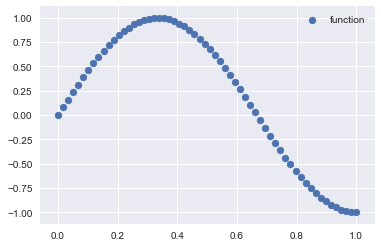

In [122]:
x = np.linspace(0,1,60)
y = np.sin(x*1.5*np.pi)
plt.scatter(x,y,label='function')
plt.legend();
plt.show();

Let's find the approximation of this plot

In [150]:
X = np.vstack((np.ones(len(x)),x)).T
cov,median = np.linalg.lstsq(X,y,rcond=-1)[0]

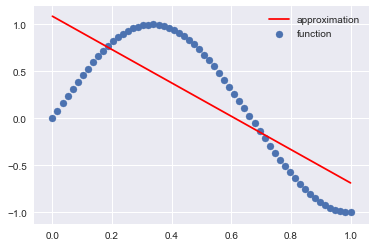

In [151]:
fig,ax = plt.subplots(figsize=(6,4))
ax.scatter(x,y,label='function')
ax.plot(x,x*c + m,color='red',label='approximation')
plt.legend()
plt.show();

What if $\textit{y}$  is defined with some noise, what should we do?

X$\Theta$ = y $\Rightarrow$ $\theta^{*}$ - the closest solution : X$\theta^{*}$ = y

Let's consider the follow basic loss function that is defined as follow:
$$L(\theta, \theta^{*}) = (\theta - \theta^{*})^{2}$$
$$(X\theta - y)^{T}(X\theta - y) \rightarrow \min_{\theta}  $$

#### 2. To plot the loss function

In [152]:
def costfunction(X,y,theta):
    m = np.size(y)

    #Cost function in vectorized form
    h = X @ theta # multiplication
    J = float((1./(2*m)) * (h - y).T @ (h - y));    
    return J;

In [154]:
N_POINTS = 60 
x          = np.linspace(0,1,N_POINTS)
X          = np.vstack((np.ones(len(x)),x)).T

y          = np.sin(x * 1.5 * np.pi ) 
noise      = 1*np.random.uniform(size = N_POINTS)
y_noise    = (y + noise).reshape(-1,1)

THETA_STAR = np.linalg.lstsq(X,y, rcond=-1)[0] # theta without noise
F_STAR     = costfunction(X, y, THETA_STAR) # the value at optimal value without noise

In [153]:
#Setup of meshgrid of theta values
T0, T1 = np.meshgrid(np.linspace(-10,10,1000),np.linspace(-10,10,1000))

#Computing the cost function for each theta combination
zs = np.array(  [costfunction(X, y_noise.reshape(-1,1),np.array([t0,t1]).reshape(-1,1)) 
                     for t0, t1 in zip(np.ravel(T0), np.ravel(T1)) ] )

In [186]:
%matplotlib inline
def draw_plot(T0,T1,zs,THETA_STAR,F_STAR):
    fig,ax = plt.subplots(figsize = (16,8))
    #Z = zs.reshape(T0.shape)
    ax=fig.gca(projection='3d')
    ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
    #plt.plot(THETA_STAR[0],THETA_STAR[1],F_STAR,color='magenta')
    ax.set_xlabel(r'$\theta_0$')
    ax.set_ylabel(r'$\theta_1$')
    ax.set_zlabel('Cost function')
    ax.view_init(45, 45)
    plt.show();

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  """


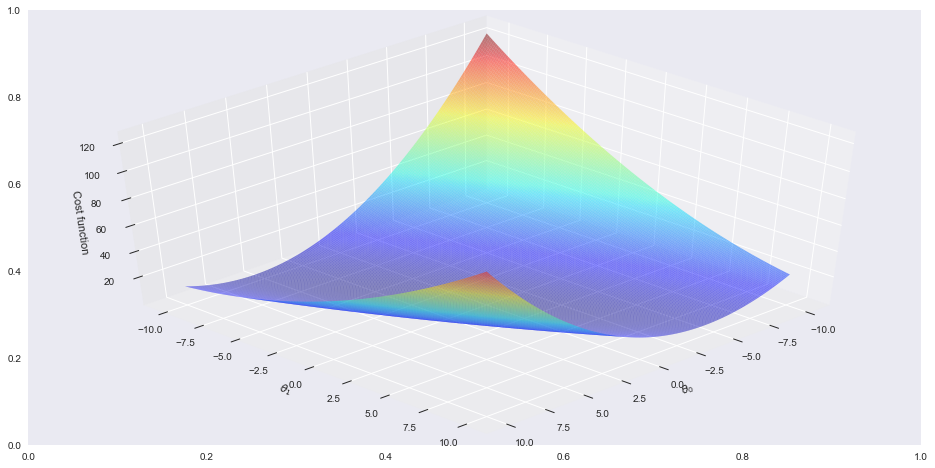

In [187]:
draw_plot(T0,T1,zs,THETA_STAR,F_STAR)

In [250]:
def contour_plot(T0,T1,zs,THETA_STAR,F_STAR):
    fig,ax = plt.subplots(figsize=(10,8))
    CS = ax.contour(T0,T1,zs,cmap='viridis',levels=np.linspace(0,30,15))
    ax.clabel(CS,fontsize=15)
    ax.plot(THETA_STAR[0],THETA_STAR[1],'r*',markersize=15)

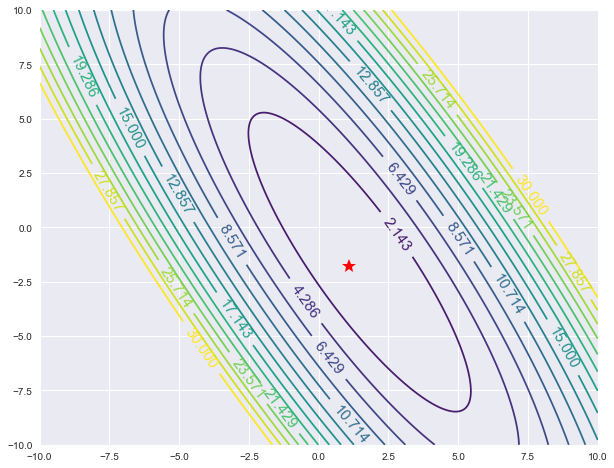

In [251]:
contour_plot(T0,T1,Z,THETA_STAR,F_STAR)

#### 3. Gradient Descent

In [190]:
def gradient_descent(X, y, theta, alpha=0.0005, num_iters = 1000):
    m = np.size(y)
    J_history = []
    theta_0_hist, theta_1_hist =[],[]
    theta_0_hist.append(theta[0,0])
    theta_1_hist.append(theta[1,0])
    J_history.append(costfunction(X,y,theta))
    for i in range(num_iters):
        h = X @ theta
        theta = theta - alpha * 1/m * (X.T@(h - y))
        J_history.append(costfunction(X,y,theta))
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])
        
    return theta, J_history, theta_0_hist, theta_1_hist

#### 4. Stochastic Gradient descent

In [200]:
def stochastic_gradient_descent(X,y,theta,alpha=0.0005,num_iters=1000,batch=10):
    m = np.size(y)
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    theta_0_hist.append(theta[0,0])
    theta_1_hist.append(theta[1,0])
    J_history.append(costfunction(X,y,theta))

    for i in range(1, num_iters):
        choice = np.random.randint(0,m,batch)
        X_b,y_b = X[choice,:],y[choice]
        h = X_b @ theta
        theta = theta - alpha*(1/batch)*(X_b.T@(h - y_b))
        J_history.append(costfunction(X,y,theta))
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])

    return theta,J_history, theta_0_hist, theta_1_hist

#### 5. Stochastic gradient descent with momentum

In [198]:
def stochastic_gradient_descent_momentum(X,y,theta,alpha = 0.0005,num_iters=1000, batch = 10, momentum = 0.1):
    #Initialisation of useful values 
    m = np.size(y)
    J_history = []
    theta_0_hist, theta_1_hist = [], [] #For plotting afterwards
    theta_0_hist.append(theta[0,0])
    theta_1_hist.append(theta[1,0])
    J_history.append(costfunction(X,y,theta))
    d = np.zeros_like(theta)

    for i in range(1, num_iters):
        choice = np.random.randint(0,m,batch)
        X_b, y_b = X[choice, :], y[choice]
        #Grad function in vectorized form
        h = X_b @ theta
        d = (- alpha * (1/batch)* (X_b.T @ (h-y_b))) + momentum*d
        theta = theta + d

        #Cost and intermediate values for each iteration
        J_history.append(costfunction(X,y,theta))
        theta_0_hist.append(theta[0,0])
        theta_1_hist.append(theta[1,0])

    return theta,J_history, theta_0_hist, theta_1_hist

#### 6. Outline

In [201]:
N_ITERS = 50
N_POINTS = 100
BATCH_SIZE = 10
MOMENTUM = 0.9
THETA_0 = np.array([0,-6]).reshape(-1,1)

theta_result, J_history, theta_0, theta_1  = gradient_descent(X,y_noise,THETA_0,alpha = 0.3,num_iters=N_ITERS)
theta_result_sgd, J_history_sgd,theta_0_sgd,theta_1_sgd  = stochastic_gradient_descent(X,y_noise,THETA_0,alpha = 0.3,num_iters=N_ITERS, batch = BATCH_SIZE)
theta_result_sgdm,J_history_sgdm,theta_0_sgdm,theta_1_sgdm = stochastic_gradient_descent_momentum(X,y_noise,THETA_0,alpha = 0.3,num_iters=N_ITERS, batch = BATCH_SIZE, momentum = MOMENTUM)

In [202]:
anglesx = np.array(theta_0)[1:] - np.array(theta_0)[:-1]
anglesy = np.array(theta_1)[1:] - np.array(theta_1)[:-1]

anglesx_sgd = np.array(theta_0_sgd)[1:] - np.array(theta_0_sgd)[:-1]
anglesy_sgd = np.array(theta_1_sgd)[1:] - np.array(theta_1_sgd)[:-1]

anglesx_sgdm = np.array(theta_0_sgdm)[1:] - np.array(theta_0_sgdm)[:-1]
anglesy_sgdm = np.array(theta_1_sgdm)[1:] - np.array(theta_1_sgdm)[:-1]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  This is separate from the ipykernel package so we can avoid doing imports until


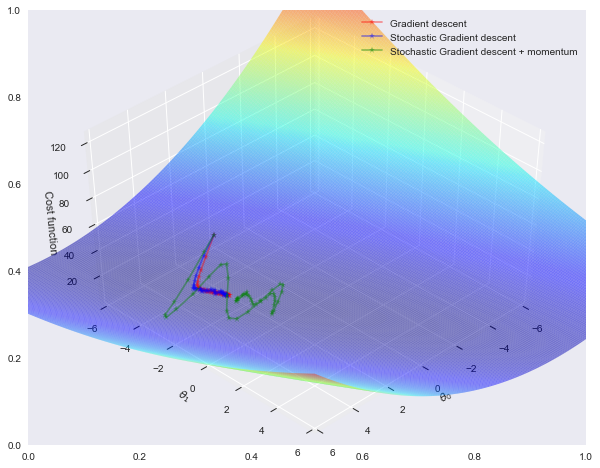

In [213]:
#ax = fig.add_subplot(2, 2, 1, projection='3d')
fig,ax = plt.subplots(figsize=(10,8))
ax = fig.gca(projection='3d')
ax.plot_surface(T0, T1, Z, rstride = 5, cstride = 5, cmap = 'jet', alpha=0.5)
ax.plot(theta_0,theta_1,J_history, marker = '*', color = 'r', alpha = .4, label = 'Gradient descent')
ax.plot(theta_0_sgd,theta_1_sgd,J_history_sgd, marker = '*', color = 'b', alpha = .4, label = 'Stochastic Gradient descent')
ax.plot(theta_0_sgdm,theta_1_sgdm,J_history_sgdm, marker = '*', color = 'g', alpha = .4, label = 'Stochastic Gradient descent + momentum')

ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel('Cost function')
ax.set_xlim([-6,6])
ax.set_ylim([-6,6])
ax.view_init(45, 45)
plt.legend();

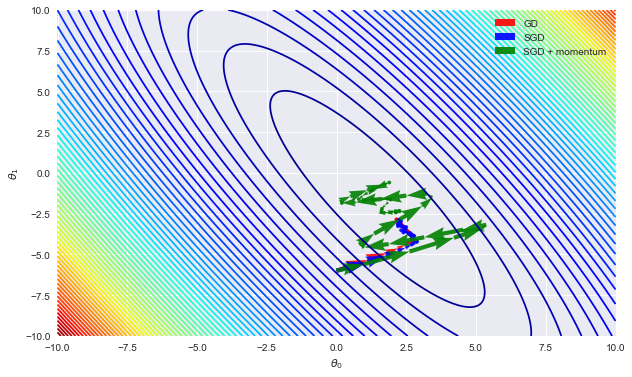

In [255]:
fig,ax = plt.subplots(figsize=(10,6))
ax.contour(T0, T1, Z, 70, cmap = 'jet')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.quiver(theta_0[:-1], theta_1[:-1], anglesx, anglesy, scale_units = 'xy', angles = 'xy', scale = 1, color = 'r', alpha = .9, label='GD')
ax.quiver(theta_0_sgd[:-1], theta_1_sgd[:-1], anglesx_sgd, anglesy_sgd, scale_units = 'xy', angles = 'xy', scale = 1, color = 'b', alpha = .9, label='SGD')
ax.quiver(theta_0_sgdm[:-1], theta_1_sgdm[:-1], anglesx_sgdm, anglesy_sgdm, scale_units = 'xy', angles = 'xy', scale = 1, color = 'g', alpha = .9, label='SGD + momentum')
plt.legend()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  import sys


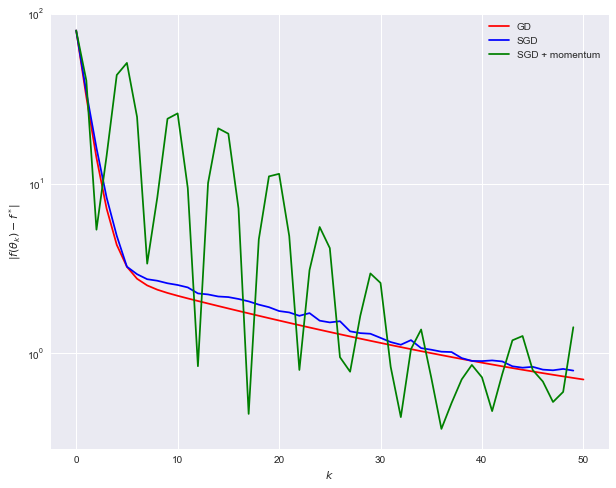

In [260]:
fig,ax = plt.subplots(figsize=(10,8))
ax.semilogy([np.abs(f - F_STAR)/F_STAR for f in J_history], label = 'GD', color = 'r')
ax.semilogy([np.abs(f - F_STAR)/F_STAR for f in J_history_sgd], label = 'SGD', color = 'b')
ax.semilogy([np.abs(f - F_STAR)/F_STAR for f in J_history_sgdm], label = 'SGD + momentum', color = 'g')
ax.set_xlabel(r'$k$')
ax.set_ylabel(r'$\|f(\theta_k) - f^*\|$')
plt.ylim([0,100])
plt.legend()
plt.show()